# Langfuse CICD - Datasets Demo - Part 3
* Notebook by Adam Lang
* Date: 12/26/2024

# Overview
* This notebook is part 3 of how to utilize Langfuse for LLMOps, focusing this time on Datasets which is a very useful feature of Langfuse 
    * First thing you need to do is Setup a Langfuse project and get credentials by going to the Langfuse dashboard link: cloud.langfuse.com
    * After doing that, follow steps in dashboard to create a new org --> new project --> Get API key.
    * Then create a secret .env file with the langfuse credentials, then you can proceed!

In [ ]:
# ! pip install -r ../../requirements.txt

# Datasets Demo

In [1]:
import dotenv

dotenv.load_dotenv('.env')

True

In [2]:
from langfuse import Langfuse
import openai

## create langfuse instance
langfuse = Langfuse()

### Dataset creation and with items
* Creates datasets using APIs.

In [3]:
## name dataset
dataset_name = "capital_cities"

##create dataset
langfuse.create_dataset(name = dataset_name)

Dataset(id='cm55n8aok00c3148hlonogj2x', name='capital_cities', description=None, metadata=None, project_id='cm55jr3d700vccr7b60c630rr', created_at=datetime.datetime(2024, 12, 26, 18, 14, 30, 932000, tzinfo=datetime.timezone.utc), updated_at=datetime.datetime(2024, 12, 26, 18, 14, 30, 932000, tzinfo=datetime.timezone.utc))

In [4]:
## add items to dataset
local_items = [
    {"input": {"country": "Italy"}, "expected_output": "Rome"},
    {"input": {"country": "Spain"}, "expected_output": "Madrid"},
    {"input": {"country": "Brazil"}, "expected_output": "Brasília"},
    {"input": {"country": "Japan"}, "expected_output": "Tokyo"},
    {"input": {"country": "India"}, "expected_output": "New Delhi"},
    {"input": {"country": "Canada"}, "expected_output": "Ottawa"},
    {"input": {"country": "South Korea"}, "expected_output": "Seoul"},
    {"input": {"country": "Argentina"}, "expected_output": "Buenos Aires"},
    {"input": {"country": "South Africa"}, "expected_output": "Pretoria"},
    {"input": {"country": "Egypt"}, "expected_output": "Cairo"},
]

In [5]:
## output
for item in local_items:
    langfuse.create_dataset_item(
        dataset_name = dataset_name,
        input = item["input"],
        expected_output = item["expected_output"],
    )

### Using Langchain with Datasets
- Once the Dataset is created we can evaluate the dataset using LangChain.

Here are the steps:
- Fetch the dataset from Langfuse
- Experiment with different system prompts to see which is the best
- generate evaluation metrics and upload it to dataset runs

In [6]:
## create a function to evaluate
def simple_evaluation(output, expected_output):
  return output == expected_output

In [7]:
from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage


## function to get llm output
def get_llm_output(input_message, system_message, langfuse_handler):
    ## create chat template
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_message),
            MessagesPlaceholder(variable_name="input_message")
        ]
    )

    # the model to be used
    # in CI either we can directly connect to it or run on CPU
    chat = ChatOpenAI(model = "gpt-3.5-turbo")
    ## create chain
    chain = prompt | chat | StrOutputParser()

    ## invoke llm response from chain
    response = chain.invoke(
    input = {"input_message": [HumanMessage(input_message)]},
    config={"callbacks": [langfuse_handler]}
    )

    return response

In [8]:
from tqdm import tqdm


## helper function --> evaluates dataset
def run_system_prompt_on_dataset(experiment_name, system_message):
    dataset = langfuse.get_dataset(name = dataset_name)

    for item in tqdm(dataset.items):
        langfuse_handler = item.get_langchain_handler(run_name=experiment_name)

        completion = get_llm_output(
            input_message=item.input["country"],
            system_message=system_message,
            langfuse_handler=langfuse_handler
        )

        evaluation = simple_evaluation(item.expected_output, completion)

        # output added by the langchain callback
        langfuse_handler.trace.score(
            name="exact_match",
            value=evaluation,
            data_type='BOOLEAN'
        )

    langfuse.flush()

Testing if expected output matches the llm output

In [9]:
run_system_prompt_on_dataset(
    "directly_ask_without_parser",
    "What is the capital of the following countr-y?"
)
run_system_prompt_on_dataset(
    "langchain_asking_specifically",
    "The user will input countries, respond with only the name of the capital"
)
run_system_prompt_on_dataset(
    "langchain_asking_specifically_2nd_try",
    "The user will input countries, respond with only the name of the capital. State only the name of the city."
)

100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


# Dashboard Demo
* Below we can see the result of the dataset run and see the output vs. expected output.
* Here is an example:

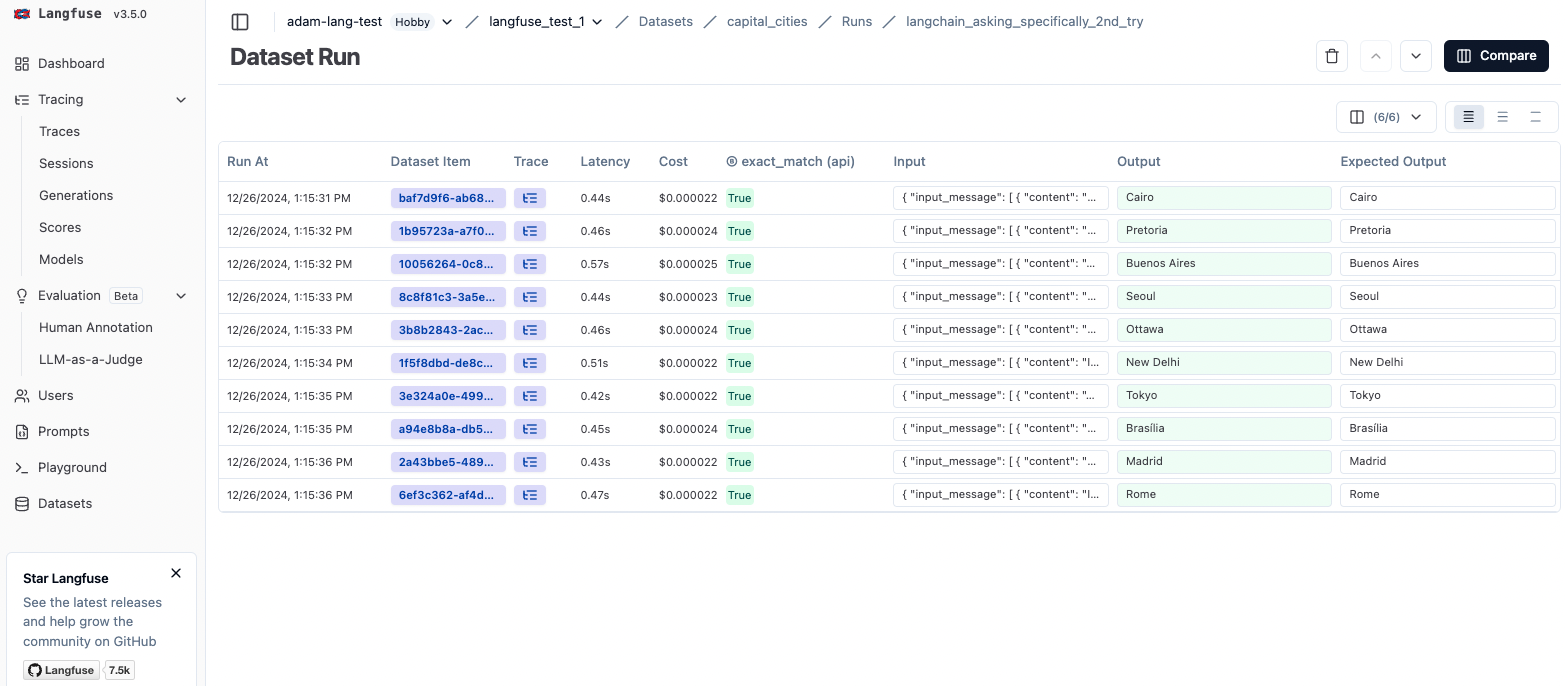